In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/NTU-research/Comformer

/content/drive/MyDrive/NTU-research/Comformer


In [4]:
%pwd

'/content/drive/MyDrive/NTU-research/Comformer'

In [5]:
from conformer import EEG_Conformer
#from densecnn import DenseCNN
model = EEG_Conformer()
#model = DenseCNN()
print(model)

EEG_Conformer(
  (linear_up): Linear(in_features=1, out_features=512, bias=True)
  (encoder): ConformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x ConformerEncoderLayer(
        (mha_layer): MultiheadAttention(
          (att): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
        )
        (convolution_module): ConvolutionModule(
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (bottleneck): Sequential(
            (0): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
            (1): GLU(dim=1)
          )
          (conv): Conv1d(512, 512, kernel_size=(15,), stride=(1,), padding=(7,), groups=512)
          (after_conv): Sequential(
            (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (1): Swish(
              (sigmoid): Sigmoid()
            )
            (2): Linear(in_features=512, out_features=512, bias=True)
        

In [6]:
model.load_state_dict(torch.load('./inference&interpretation/model_path/model101.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [7]:
# 将模型设置为评估模式
model.eval()

EEG_Conformer(
  (linear_up): Linear(in_features=1, out_features=512, bias=True)
  (encoder): ConformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x ConformerEncoderLayer(
        (mha_layer): MultiheadAttention(
          (att): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
        )
        (convolution_module): ConvolutionModule(
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (bottleneck): Sequential(
            (0): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
            (1): GLU(dim=1)
          )
          (conv): Conv1d(512, 512, kernel_size=(15,), stride=(1,), padding=(7,), groups=512)
          (after_conv): Sequential(
            (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (1): Swish(
              (sigmoid): Sigmoid()
            )
            (2): Linear(in_features=512, out_features=512, bias=True)
        

In [8]:
print("1. Prepare dataset...")
test_set = torch.load("./EEG_DATA/Epilept/test.pt")
test_data = test_set["samples"].float()
test_labels = test_set["labels"]

1. Prepare dataset...


# 计算Grad-CAM

## 正向传播，可以一次性输入多个xTest

In [9]:
#target_layers = [model.encoder.layers[-1].convolution_module.after_conv[-1]]
#target_layers = [model.encoder.layers[-1].mha_layer.att.out_proj]
#target_layers = [model.encoder.layers[-1].norm1]
target_layers = [model.encoder.norm] # Conformer用这个
#target_layers = [model.dense_inception.conv1x1_76.conv] # DenseCNN用这个
target_layers# 这个是最后一层，进入fc层之前的那一层

[LayerNorm(
   (norm): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
 )]

In [10]:
input_tensor = test_data[0:2]
input_tensor.shape

torch.Size([2, 1, 124])

In [11]:
target_category = test_labels[0:2]
target_category.shape

torch.Size([2])

In [12]:
%pwd

'/content/drive/MyDrive/NTU-research/Comformer'

In [13]:
class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targeted intermediate layers """

    def __init__(self, model, target_layers, reshape_transform):
        self.model = model
        self.gradients = []
        self.activations = []
        self.reshape_transform = reshape_transform
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(
                    self.save_activation))
            # Backward compatibility with older pytorch versions:
            if hasattr(target_layer, 'register_full_backward_hook'):
                self.handles.append(
                    target_layer.register_full_backward_hook(
                        self.save_gradient))
            else:
                self.handles.append(
                    target_layer.register_backward_hook(
                        self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output
        if self.reshape_transform is not None:
            activation = self.reshape_transform(activation)
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, grad_input, grad_output):
        # Gradients are computed in reverse order
        grad = grad_output[0]
        if self.reshape_transform is not None:
            grad = self.reshape_transform(grad)
        self.gradients = [grad.cpu().detach()] + self.gradients

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        return self.model(x)

    def release(self):
        for handle in self.handles:
            handle.remove()


In [14]:
activations_and_grads = ActivationsAndGradients(model, target_layers, reshape_transform = None)
output = activations_and_grads(input_tensor)

In [15]:
output.shape

torch.Size([2])

In [16]:
output

tensor([0.9948, 0.8783], grad_fn=<SqueezeBackward0>)

In [17]:

target_category[0]

tensor(1., dtype=torch.float64)

In [18]:
model.zero_grad()

loss = 0
for i in range(len(target_category)):
    loss = loss + output[i]#这里把第二个维度去掉了，因为我们用的是sigmoid不是softmax

In [19]:
(output[0]+output[1]).backward(retain_graph=True)

## 算完了gradient，现在开始计算weights和总的cam

In [20]:
activations_list = [a.cpu().data.numpy()
                            for a in activations_and_grads.activations]
grads_list = [g.cpu().data.numpy()
                      for g in activations_and_grads.gradients]
#target_size = self.get_target_width_height(input_tensor)

In [21]:
activations_list[0].shape

(2, 124, 512)

In [22]:
grads_list[0].shape

(2, 124, 512)

In [23]:
activation1 = activations_list[0][0]
activation1.shape

(124, 512)

In [24]:
activation2 = activations_list[0][1]
activation2.shape

(124, 512)

In [25]:
grads1 = grads_list[0][0]
grads1.shape

(124, 512)

In [26]:
grads2 = grads_list[0][0]
grads2.shape

(124, 512)

## weights的计算

In [27]:
weights1 = np.mean(grads1, axis = 0)
weights1.shape

(512,)

In [28]:
weights2 = np.mean(grads2, axis = 0)
weights2.shape

(512,)

## 计算cam

In [29]:
activation1 = np.transpose(activation1)
activation2 = np.transpose(activation2)
activation1.shape

(512, 124)

In [30]:
cam1=np.matmul(weights1, activation1)
#cam1[cam1 < 0] = 0
cam1.shape

(124,)

In [31]:
cam2=np.matmul(weights2, activation2)
#cam2[cam2 < 0] = 0
cam2.shape

(124,)

# 开始画没上色的heatmap

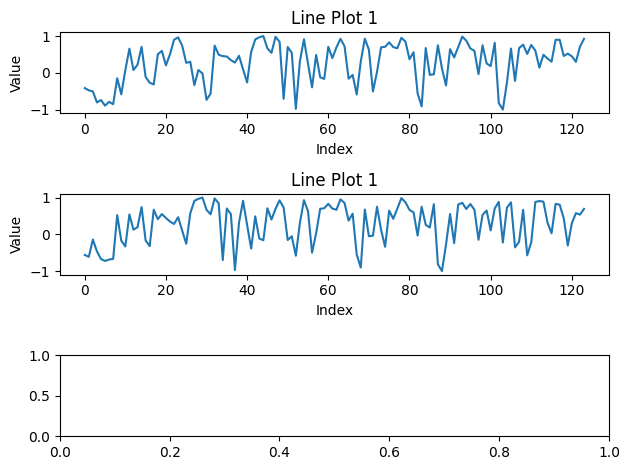

NameError: ignored

In [32]:
# 创建子图布局
fig, axes = plt.subplots(3, 1)

# 绘制第一张图
heatdata1 = np.reshape(cam1, (1, 124))
#统一normalise到(0,1)区间里
#归一化系数k
k1 = 2/(np.max(heatdata1)-np.min(heatdata1))
heatdata1=[-1 + k1*(x-np.min(heatdata1)) for x in heatdata1]
#heatdata1 = (heatdata1 - np.mean(heatdata1))/ np.sqrt(np.sum(heatdata1**2)/124)
axes[0].plot(heatdata1[0])
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Value')
axes[0].set_title('Line Plot 1')


# 绘制第二张图
heatdata2 = np.reshape(cam2, (1, 124))
#统一normalise到(0,1)区间里
#归一化系数k
k2 = 2/(np.max(heatdata2)-np.min(heatdata2))
heatdata2=[-1 + k2*(x-np.min(heatdata2)) for x in heatdata2]
#heatdata1 = (heatdata1 - np.mean(heatdata1))/ np.sqrt(np.sum(heatdata1**2)/124)
axes[1].plot(heatdata2[0])
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Value')
axes[1].set_title('Line Plot 1')




# 调整子图布局
plt.tight_layout()

# 显示图形
plt.show()
print(f"The max value is:{np.max(heatdata)}")

# 上色

In [33]:
test_data[0][0].shape

torch.Size([124])

In [34]:
rawsignal = test_data[0][0].numpy()
rawsignal.shape

(124,)

In [35]:
xx= np.arange(1, 125)
xx.shape

(124,)

In [36]:
points = np.array([xx, rawsignal]).T.reshape(-1, 1, 2)
points.shape

(124, 1, 2)

In [37]:
segments = np.concatenate([points[:-1], points[1:]], axis=1)
segments.shape

(123, 2, 2)

In [38]:
heatdata1 = np.squeeze(heatdata1)
heatdata1.shape

(124,)

the maxvalue is:0.8039215803146362


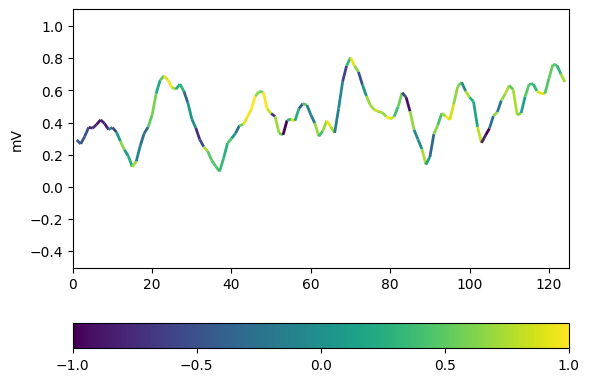

In [39]:
from matplotlib.collections import LineCollection
fig,axes = plt.subplots()

maxvalue=np.max(np.abs(rawsignal))
print(f"the maxvalue is:{maxvalue}")
axes.set_ylim([-maxvalue+0.3, maxvalue+0.3])
axes.set_xlim([0,125])
axes.set_ylabel("mV")


norm = plt.Normalize(-1, 1)
lc = LineCollection(segments, cmap='viridis', norm=norm)
lc.set_array(heatdata1)
lc.set_linewidth(2)
axes.add_collection(lc)
fig.colorbar(lc, orientation = "horizontal",ticks = [-1, -0.5, 0, 0.5, 1])
plt.show()